### LSST AGN SC Classification Example II

Gordon Richards and Weixiang Yu, Drexel University, May 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.

It specifically contains example code illustrating Pandas, Matplotlib, and SciKit-Learn tools that can be used to develop intitial selection algorithms for AGN in the LSST context.

Where possible and appropriate, we make reference to [Jake Vanderplas' Handbook for Data Science Python]( https://jakevdp.github.io/PythonDataScienceHandbook/).

In [19]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb
import seaborn as sea
from scipy import stats

#So that plots will be displayed inline
%matplotlib inline 

import palettable

In [20]:
## If using SciServer
# See Get_started.ipynb
init()

In [21]:
def figsze(hscale, vscale=(np.sqrt(5.0)-1.0)/2.0, fig_width_pt = 800.0):
    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width#*vscale                   # height in inches
    fig_size = [fig_width/2+2,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.1,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 20,
    "legend.fontsize": 18,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 20,              # Font size of numbers 
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

In [22]:
def contour_scatter(x, y, exkernel=None, ax=None, color='C0', cmap='Blues_r',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    cmap=cmap,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y,
                   color=color,
                   **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]


Start by loading up the quasar and non-AGN databases into [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [23]:
qso_df = get_qso_cat()
qso_df.head(3)

,train_id,ra,dec,z,z_err,thing_id,specobjid,spec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,0,310.0377,-1.005592,2.167268,0.000676,<NA>,276352159556042752,7,8647475119809364088,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244397,0.177257,0.134408,0.095297,6,206,0.083856,19.312095,18.875304,18.513243,18.263452,18.025003,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605912576,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,6401869206833334272,NaN,NaN,23.184412,0.436260,1.696868,0.0,0.436792,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848,-0.609215,-0.206735,0.225240,55,qso
1,3,311.6088,0.393812,0.333015,0.000351,<NA>,537282917827608576,7,8647475121420632840,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,3,206,0.051798,19.489293,18.512125,17.722814,17.683700,16.975958,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,2468467513536552960,21.218325,0.06131,21.052940,0.047003,0.742009,0.0,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829,0.044235,0.075344,-0.149525,63,qso
2,4,312.3636,0.718380,1.699121,0.000973,<NA>,314071864353751040,7,8647475121957832451,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,3,206,0.154056,21.131835,20.595028,20.152444,19.718245,19.668558,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360380928,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902,-0.776679,0.635052,-0.486411,47,qso


In [24]:
vstar_df = get_var_cat()
vstar_df.head(3)

,train_id,ivz_id,ra,dec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,specobjid,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,100012,7906731,37.49921,1.248179,8647475122531991636,0.018714,0.003049,0.003790,0.005687,0.019610,0.125279,0.092179,0.066856,0.050695,0.035943,6,0,206,0.080803,20.872561,19.853071,19.798564,19.817875,19.853337,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080648,2501387338283191808,-1.088944,0.509479,-0.63834,1.135483,-1.290321,0.843259,3785207454586900992,NaN,NaN,22.384655,0.173528,0.940821,0.0,1.019490,0.054507,-0.019311,-0.035462,15652.252822,16248.984216,43707.649029,42931.448916,4.215728e+04,-0.63834,-1.290321,-1.088944,64,vStar
1,100016,7907235,337.49950,1.230992,8647475122505712198,0.033394,0.001987,0.000994,0.000829,0.001670,0.414332,0.304861,0.221111,0.167662,0.118874,6,0,206,0.060045,21.113058,18.763849,17.449119,16.766768,16.391656,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229563,2702582302420520960,1.326021,0.155768,16.47697,0.339029,-1.713997,0.261593,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2.349210,1.314730,0.682351,0.375113,12535.479466,13017.556004,380520.448083,713376.049325,1.026504e+06,16.47697,-1.713997,1.326021,62,vStar
2,100017,7907288,337.49980,-0.002995,8647475120895099460,0.031712,0.004624,0.003833,0.004397,0.014379,0.368637,0.271240,0.196725,0.149171,0.105764,6,0,206,0.019169,21.165513,20.076470,19.583955,19.429559,19.355206,337.499836,-0.002989,620326,14.699725,2.305519,14.990035,2.25308,0.269771,0.01114,0.130273,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1.089043,0.492516,0.154395,0.074353,11942.406820,12402.802438,53261.744502,61397.889774,6.686797e+04,NaN,NaN,NaN,113,vStar


Actually, better yet, let's load both the quasars and non-AGNs into a single DataFrame, where the class is indicated by `class`. (**qso**, **vStar** and **gal**)  This will make our lives easier in terms of getting the training data into the format that [SciKit-Learn](https://scikit-learn.org/stable/index.html) prefers.

In [25]:
# select only qso and vStar
all_df = get_train_cat()
all_df = all_df[all_df['class'] !='gal']
all_df.head(5)

,class,class_star_ch1,class_star_ch2,dec,dec_sp,dered_g,dered_i,dered_r,dered_u,dered_z,extinction_g,extinction_i,extinction_r,extinction_u,extinction_z,flux_auto_ch1,flux_auto_ch2,fluxerr_auto_ch1,fluxerr_auto_ch2,fuv_mag,fuv_magerr,gaia_id,galex_id,ivz_id,lcN,mpstype,nuv_mag,nuv_magerr,parallax,parallax_error,pmdec,pmdec_error,pmra,pmra_error,psFlux[g],psFlux[i],psFlux[r],psFlux[u],psFlux[z],psParallax,psPm[0],psPm[1],psfmagerr_g,psfmagerr_i,psfmagerr_r,psfmagerr_u,psfmagerr_z,ra,ra_sp,run,sdss_objid,spec,spec_subclass,specobjid,spies_id,src2gaia,src2galex,src2photo,src2spies,stdColor[0],stdColor[1],stdColor[2],stdColor[3],thing_id,train_id,type,z,z_err
0,qso,NaN,NaN,-1.005592,NaN,18.875304,18.263452,18.513243,19.312095,18.025003,0.244397,0.134408,0.177257,0.332155,0.095297,NaN,NaN,NaN,NaN,NaN,NaN,4226318531605912576,6401869206833334272,<NA>,55,0.0,23.184412,0.436260,0.225240,0.283972,-0.206735,0.305267,-0.609215,0.464463,68419.255122,179737.984132,142798.907734,65942.328054,228014.565848,0.225240,-0.609215,-0.206735,0.003265,0.002969,0.003569,0.008446,0.005960,310.0377,NaN,206,8647475119809364088,7,NaN,276352159556042752,<NA>,0.024083,1.696868,0.083856,NaN,0.436792,0.362060,0.249792,0.238449,<NA>,0,6,2.167268,0.000676
1,qso,NaN,NaN,0.393812,NaN,18.512125,17.683700,17.722814,19.489293,16.975958,0.364045,0.200210,0.264036,0.494767,0.141952,NaN,NaN,NaN,NaN,21.218325,0.061310,4228017414511443968,2468467513536552960,<NA>,63,0.0,21.052940,0.047003,-0.149525,0.160723,0.075344,0.179892,0.044235,0.275073,58115.957521,306580.434350,295732.889174,56011.332155,599285.639829,-0.149525,0.044235,0.075344,0.001996,0.002298,0.001869,0.011383,0.003088,311.6088,NaN,206,8647475121420632840,7,NaN,537282917827608576,<NA>,0.092993,0.742009,0.051798,NaN,0.977168,0.789311,0.039115,0.707741,<NA>,3,3,0.333015,0.000351
2,qso,NaN,NaN,0.718380,NaN,20.595028,19.718245,20.152444,21.131835,19.668558,0.387692,0.213215,0.281186,0.526905,0.151172,NaN,NaN,NaN,NaN,NaN,NaN,4228378535360380928,<NA>,<NA>,47,NaN,NaN,NaN,-0.486411,0.729782,0.635052,1.033818,-0.776679,2.051325,12794.084912,47059.204593,31547.575429,12319.895839,50039.124902,-0.486411,-0.776679,0.635052,0.009041,0.007637,0.007869,0.037532,0.022191,312.3636,NaN,206,8647475121957832451,7,NaN,314071864353751040,<NA>,0.218568,NaN,0.154056,NaN,0.536807,0.442585,0.434199,0.049687,<NA>,4,3,1.699121,0.000973
3,qso,NaN,NaN,0.834625,NaN,20.042354,19.652183,19.884427,20.403761,19.501243,0.382986,0.210627,0.277773,0.520510,0.149337,NaN,NaN,NaN,NaN,22.338091,0.160893,<NA>,2468502697908636672,<NA>,108,0.0,21.475634,0.056155,NaN,NaN,NaN,NaN,NaN,NaN,25029.261444,50012.543099,40383.598908,24118.091101,58422.366330,NaN,NaN,NaN,0.005620,0.007393,0.006083,0.020328,0.019640,312.4020,NaN,206,8647475121957831705,7,NaN,314071864311808000,<NA>,NaN,0.364936,0.160105,NaN,0.361406,0.157927,0.232244,0.150940,<NA>,5,3,0.475306,0.000354
4,qso,NaN,NaN,0.455123,NaN,20.005581,19.760675,19.965770,19.954390,19.543730,0.338089,0.185935,0.245210,0.459490,0.131831,NaN,NaN,NaN,NaN,NaN,NaN,4228358022596119040,2468537882278632960,<NA>,50,0.0,23.030893,0.171892,0.250211,0.772921,-0.107082,1.024258,1.965712,2.234255,37865.005535,45254.921252,37467.915153,36491.532269,56170.337863,0.250211,1.965712,-0.107082,0.005312,0.007587,0.006064,0.013942,0.019144,312.4340,NaN,106,8647474692461166737,7,NaN,314353417491316736,<NA>,0.100156,0.508715,0.150507,NaN,-0.051192,0.039811,0.205095,0.216945,<NA>,6,6,2.080289,0.001066


What columns are available to us?

In [26]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 0 to 158803
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   class             49528 non-null  object 
 1   class_star_ch1    7809 non-null   float64
 2   class_star_ch2    7809 non-null   float64
 3   dec               49528 non-null  float64
 4   dec_sp            7809 non-null   float64
 5   dered_g           49528 non-null  float64
 6   dered_i           49528 non-null  float64
 7   dered_r           49528 non-null  float64
 8   dered_u           49528 non-null  float64
 9   dered_z           49528 non-null  float64
 10  extinction_g      49528 non-null  float64
 11  extinction_i      49528 non-null  float64
 12  extinction_r      49528 non-null  float64
 13  extinction_u      49528 non-null  float64
 14  extinction_z      49528 non-null  float64
 15  flux_auto_ch1     7809 non-null   float64
 16  flux_auto_ch2     7809 non-null   float

Note that the different features/attributes/columns in the dataframe have different numbers of non-null entries.  One has to decide how to handle these.  Either by dropping objects with nulls, dropping columns with too many nulls, or replacing the null values with some sort of average (so that that objects or column can still be used even if that feature is not accurate).

Note also the use of `stdColor[0]` etc, which is the way that "colors" are stored in the current [LSST Data Model](https://lse-163.lsst.io/).  Unfortunately, one of the few downsides of Pandas is that it can't handle vectors columns like this, so they are currently split up in a way that is somewhat awkward.

For now, let's just use the columns in the following cell.  In the end, we'll use many more features than this (and we'll want to include columns that parameterize the variability -- if not use the light curves directly), but this combines features of different types from different sources, which is what we want to illustrate here.

In [27]:
collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','parallax','pmra','pmdec','class']
#collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','flux_auto_ch1','flux_auto_ch2','class']
train_df = all_df[collist]

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 0 to 158803
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           49528 non-null  float64
 1   dec          49528 non-null  float64
 2   stdColor[0]  49528 non-null  float64
 3   stdColor[1]  49528 non-null  float64
 4   stdColor[2]  49528 non-null  float64
 5   stdColor[3]  49528 non-null  float64
 6   parallax     33543 non-null  float64
 7   pmra         33543 non-null  float64
 8   pmdec        33543 non-null  float64
 9   class        49528 non-null  object 
dtypes: float64(9), object(1)
memory usage: 4.2+ MB


That still leaves us with some features with null values.  For now, let's drop those objects.  [Other options](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html) are also available.

In [29]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33543 entries, 0 to 158803
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           33543 non-null  float64
 1   dec          33543 non-null  float64
 2   stdColor[0]  33543 non-null  float64
 3   stdColor[1]  33543 non-null  float64
 4   stdColor[2]  33543 non-null  float64
 5   stdColor[3]  33543 non-null  float64
 6   parallax     33543 non-null  float64
 7   pmra         33543 non-null  float64
 8   pmdec        33543 non-null  float64
 9   class        33543 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.8+ MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  "y" are the classes for each of those objects.

We'll next build both "y" and "X" (the order is important) from our training dataframe.  

"y" is just the values of `class`.  Note that Pandas dataframes have meta data associated with them.  Using the `values` attribute extracts just the numbers, which is what SciKit-Learn wants.

Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Note that we haven't dropped the RA and Dec from X.  They probably aren't that useful, but they shouldn't hurt either.

In [30]:
y = train_df['class'].values.copy()
y

array(['qso', 'qso', 'qso', ..., 'vStar', 'vStar', 'vStar'], dtype=object)

In [31]:
X = train_df.drop('class',axis=1).values
X
print(X.shape)

(33543, 9)


In [32]:
starmask = (y=='vStar')
qsomask = (y=='qso')
print(starmask.sum())
print(qsomask.sum())

23422
10121



The rest of this notebook will follow the [example from Jake's book](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), but using the data from the AGN training set.

#Old way that I was making color-color plots
fig, ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].scatter(train_df[starmask]['stdColor[0]'],train_df[starmask]['stdColor[1]'],label='stars',alpha=0.5)
ax[0,0].scatter(train_df[qsomask]['stdColor[0]'],train_df[qsomask]['stdColor[1]'],label='qsos',alpha=0.5)
ax[0,0].legend(loc='lower right')
ax[0,0].set_xlim(-1,6)
ax[0,0].set_ylim(-1,3)
ax[0,0].set_xlabel('u-g')
ax[0,0].set_ylabel('g-r')

ax[0,1].scatter(train_df[starmask]['stdColor[1]'],train_df[starmask]['stdColor[2]'],label='stars',alpha=0.5)
ax[0,1].scatter(train_df[qsomask]['stdColor[1]'],train_df[qsomask]['stdColor[2]'],label='qsos',alpha=0.5)
ax[0,1].legend(loc='lower right')
ax[0,1].set_xlim(-1,3)
ax[0,1].set_ylim(-1,2.5)
ax[0,1].set_xlabel('g-r')
ax[0,1].set_ylabel('r-i')

ax[1,0].scatter(train_df[starmask]['stdColor[2]'],train_df[starmask]['stdColor[3]'],label='stars',alpha=0.5)
ax[1,0].scatter(train_df[qsomask]['stdColor[2]'],train_df[qsomask]['stdColor[3]'],label='qsos',alpha=0.5)
ax[1,0].legend(loc='lower right')
ax[1,0].set_xlim(-1,2.5)
ax[1,0].set_ylim(-1,1.5)
ax[1,0].set_xlabel('r-i')
ax[1,0].set_ylabel('i-z')

#ax[1,1].legend(loc='lower right')


[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0. 1. 2. 3. 4. 5. 6. 7.]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]


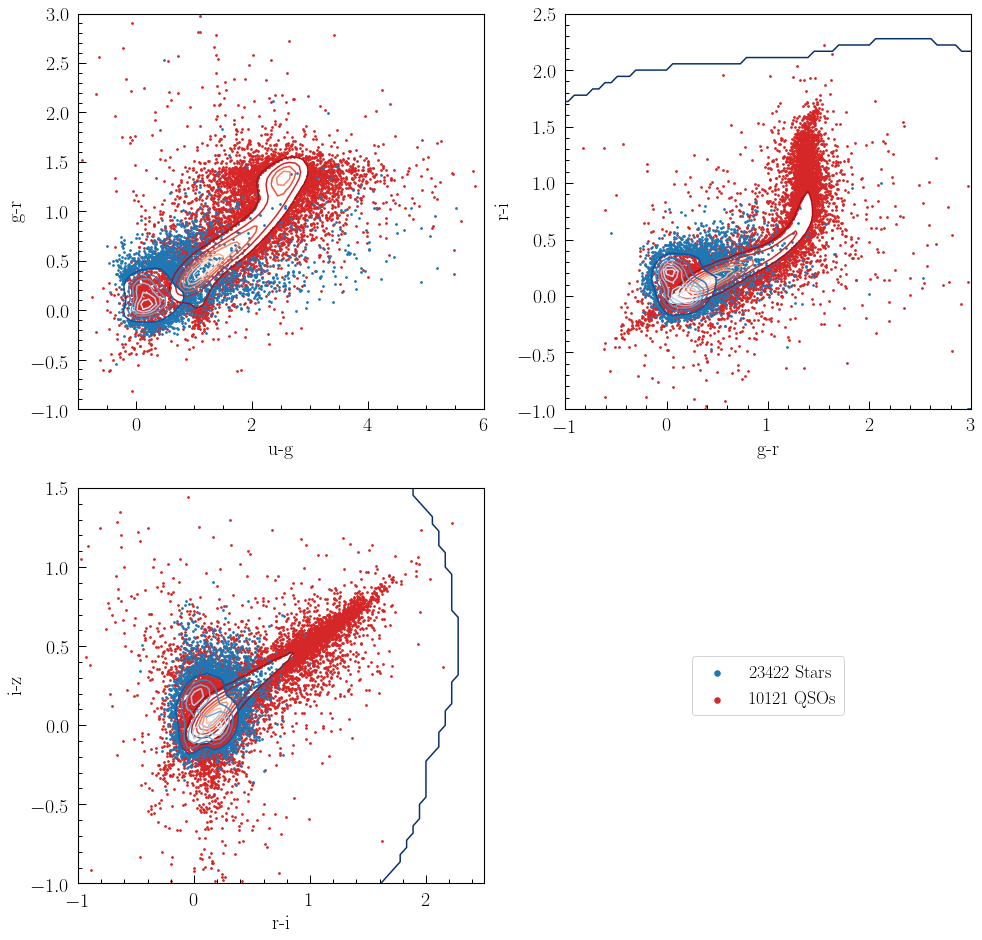

In [35]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=0

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[starmask]['stdColor[0]'], train_df[starmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color='C3', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[0]'], train_df[qsomask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Blues_r', color='C0', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,6)
        axis.set_ylim(-1,3)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[starmask]['stdColor[1]'], train_df[starmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color='C3', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[1]'], train_df[qsomask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Blues_r', color='C0', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,3)
        axis.set_ylim(-1,2.5)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[starmask]['stdColor[2]'], train_df[starmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color='C3', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[2]'], train_df[qsomask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Blues_r', color='C0', kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        axis.set_xlim(-1,2.5)
        axis.set_ylim(-1,1.5)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        handles = [plt.scatter([], [], color='C0', s=30),plt.scatter([],[],color='C3',s=30)]
        labels  = [str(starmask.sum())+' Stars',str(qsomask.sum())+' QSOs']
        legend = axis.legend(handles, labels, loc='center')    
        
        

---

Let's start by seeing how well a RF does at classification using colors alone.

In [37]:
Xcolors = train_df.drop(['class', 'ra', 'dec', 'parallax', 'pmra', 'pmdec'],axis=1).values
Xcolors
print(Xcolors.shape)

(33543, 4)


In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
#Instantiate a model with the parameters we decide upon.
model = RandomForestClassifier(n_estimators=200)

In [41]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scoresColors=cross_val_score(model, Xcolors, y, cv=5)
scoresColors.mean()

0.9361424764907417

In [42]:
#Get actual predicted values so that we can make plots
from sklearn.model_selection import cross_val_predict
ypredColors = cross_val_predict(model, Xcolors, y, cv=5)

In [43]:
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(y,ypredColors).ravel()
print(tp, tn, fp, fn)

9236 22162 1260 885


In [44]:
#Make masks for the above to aid in plotting
tpmask = ((y=='qso') & (ypredColors=='qso'))
tnmask = ((y=='vStar') & (ypredColors=='vStar'))
fpmask = ((y=='vStar') & (ypredColors=='qso'))
fnmask = ((y=='qso') & (ypredColors=='vStar'))
print(tpmask.sum(),tnmask.sum(),fpmask.sum(),fnmask.sum())

9236 22162 1260 885


In [45]:
from sklearn.metrics import classification_report
target_names=np.unique(train_df['class'])
print(classification_report(y, ypredColors, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.88      0.91      0.90     10121
       vStar       0.96      0.95      0.95     23422

    accuracy                           0.94     33543
   macro avg       0.92      0.93      0.92     33543
weighted avg       0.94      0.94      0.94     33543



Now make plots of the results.

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]


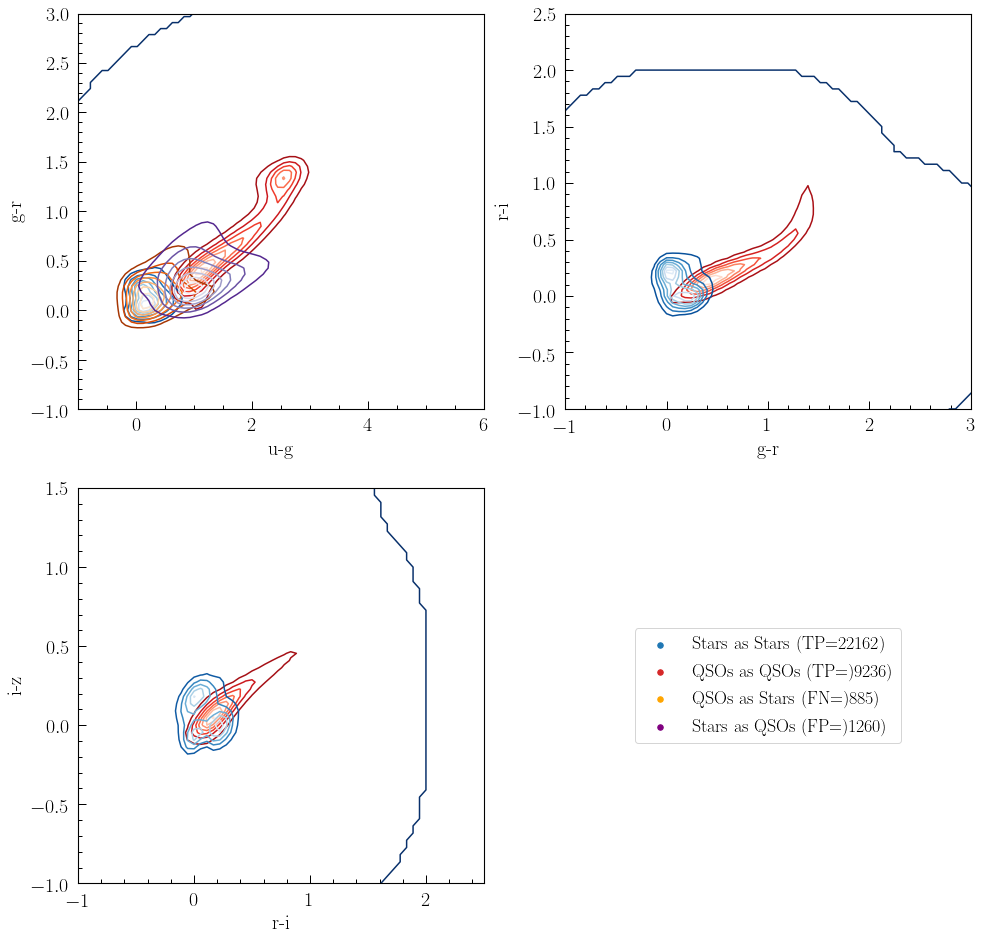

In [48]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask]['stdColor[0]'], train_df[tnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[0]'], train_df[tpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,6)
        axis.set_ylim(-1,3)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask]['stdColor[1]'], train_df[tnmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[1]'], train_df[tpmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,3)
        axis.set_ylim(-1,2.5)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask]['stdColor[2]'], train_df[tnmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[2]'], train_df[tpmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,2.5)
        axis.set_ylim(-1,1.5)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        handles = [plt.scatter([], [], color='red', s=30),plt.scatter([],[],color='blue',s=30),plt.scatter([],[],color='orange',s=30),plt.scatter([],[],color='purple',s=30)]
        labels  = ['Stars as Stars (TP='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    
        

fig, ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].scatter(train_df[tnmask]['stdColor[0]'],train_df[tnmask]['stdColor[1]'],label='stars',alpha=0.5)
ax[0,0].scatter(train_df[tpmask]['stdColor[0]'],train_df[tpmask]['stdColor[1]'],label='qsos',alpha=0.5)
ax[0,0].scatter(train_df[fpmask]['stdColor[0]'],train_df[fpmask]['stdColor[1]'],label='FP',alpha=0.5)
ax[0,0].scatter(train_df[fnmask]['stdColor[0]'],train_df[fnmask]['stdColor[1]'],label='FN',alpha=0.5)
ax[0,0].legend(loc='lower right')
ax[0,0].set_xlim(-1,6)
ax[0,0].set_ylim(-1,3)
ax[0,0].set_xlabel('u-g')
ax[0,0].set_ylabel('g-r')

ax[0,1].scatter(train_df[tnmask]['stdColor[1]'],train_df[tnmask]['stdColor[2]'],label='stars',alpha=0.5)
ax[0,1].scatter(train_df[tpmask]['stdColor[1]'],train_df[tpmask]['stdColor[2]'],label='qsos',alpha=0.5)
ax[0,1].scatter(train_df[fpmask]['stdColor[1]'],train_df[fpmask]['stdColor[2]'],label='FP',alpha=0.5)
ax[0,1].scatter(train_df[fnmask]['stdColor[1]'],train_df[fnmask]['stdColor[2]'],label='FN',alpha=0.5)
ax[0,1].legend(loc='lower right')
ax[0,1].set_xlim(-1,3)
ax[0,1].set_ylim(-1,2.5)
ax[0,1].set_xlabel('g-r')
ax[0,1].set_ylabel('r-i')

ax[1,0].scatter(train_df[tnmask]['stdColor[2]'],train_df[tnmask]['stdColor[3]'],label='stars',alpha=0.5)
ax[1,0].scatter(train_df[tpmask]['stdColor[2]'],train_df[tpmask]['stdColor[3]'],label='qsos',alpha=0.5)
ax[1,0].scatter(train_df[fpmask]['stdColor[2]'],train_df[fpmask]['stdColor[3]'],label='FP',alpha=0.5)
ax[1,0].scatter(train_df[fnmask]['stdColor[2]'],train_df[fnmask]['stdColor[3]'],label='FN',alpha=0.5)
ax[1,0].legend(loc='lower right')
ax[1,0].set_xlim(-1,2.5)
ax[1,0].set_ylim(-1,1.5)
ax[1,0].set_xlabel('r-i')
ax[1,0].set_ylabel('i-z')

#ax[1,1].legend(loc='lower right')

fig, ax = plt.subplots(2,2,figsize=(16,16))

handles, labels = (0, 0)

for i, axis in enumerate(ax.ravel()):

    if i==0: 
        axis.scatter(train_df[tnmask]['stdColor[0]'],train_df[tnmask]['stdColor[1]'],label='stars',alpha=0.5)
        axis.scatter(train_df[tpmask]['stdColor[0]'],train_df[tpmask]['stdColor[1]'],label='qsos',alpha=0.5)
        axis.scatter(train_df[fpmask]['stdColor[0]'],train_df[fpmask]['stdColor[1]'],label='FP',alpha=0.5)
        axis.scatter(train_df[fnmask]['stdColor[0]'],train_df[fnmask]['stdColor[1]'],label='FN',alpha=0.5)
        axis.set_xlim(-1,6)
        axis.set_ylim(-1,3)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        axis.scatter(train_df[tnmask]['stdColor[1]'],train_df[tnmask]['stdColor[2]'],label='stars',alpha=0.5)
        axis.scatter(train_df[tpmask]['stdColor[1]'],train_df[tpmask]['stdColor[2]'],label='qsos',alpha=0.5)
        axis.scatter(train_df[fpmask]['stdColor[1]'],train_df[fpmask]['stdColor[2]'],label='FP',alpha=0.5)
        axis.scatter(train_df[fnmask]['stdColor[1]'],train_df[fnmask]['stdColor[2]'],label='FN',alpha=0.5)
        axis.set_xlim(-1,6)
        axis.set_ylim(-1,3)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        axis.set_xlim(-1,3)
        axis.set_ylim(-1,2.5)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        axis.scatter(train_df[tnmask]['stdColor[2]'],train_df[tnmask]['stdColor[3]'],label='Star as Star (TN='+str(tnmask.sum())+')',alpha=0.5)
        axis.scatter(train_df[tpmask]['stdColor[2]'],train_df[tpmask]['stdColor[3]'],label='QSO as QSO (TP)',alpha=0.5)
        axis.scatter(train_df[fpmask]['stdColor[2]'],train_df[fpmask]['stdColor[3]'],label='Star as QSO (FP)',alpha=0.5)
        axis.scatter(train_df[fnmask]['stdColor[2]'],train_df[fnmask]['stdColor[3]'],label='QSO as Star (FN)',alpha=0.5)      
        axis.set_xlim(-1,2.5)
        axis.set_ylim(-1,1.5)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')
        
    if i == 2:
        handles, labels = axis.get_legend_handles_labels()

    if i == 3:
        axis.set_axis_off()
        legend = axis.legend(handles, labels, loc='center')




Now add the GAIA data

In [52]:
X2 = train_df.drop(['class', 'ra', 'dec'],axis=1).values
X2
print(X2.shape)

(33543, 7)


In [53]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scores2=cross_val_score(model, X2, y, cv=5)
scores2.mean()

0.9466068861655144

In [55]:
#Get actual predicted values so that we can make plots
ypred2 = cross_val_predict(model, X2, y, cv=5)

In [56]:
from sklearn.metrics import confusion_matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y,ypred2).ravel()
print(tn2, fp2, fn2, tp2)

9460 661 1115 22307


In [57]:
#Make masks for the above to aid in plotting
tpmask2 = ((y=='qso') & (ypred2=='qso'))
tnmask2 = ((y=='vStar') & (ypred2=='vStar'))
fpmask2 = ((y=='vStar') & (ypred2=='qso'))
fnmask2 = ((y=='qso') & (ypred2=='vStar'))

In [58]:
target_names=np.unique(train_df['class'])
print(classification_report(y, ypred2, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.89      0.93      0.91     10121
       vStar       0.97      0.95      0.96     23422

    accuracy                           0.95     33543
   macro avg       0.93      0.94      0.94     33543
weighted avg       0.95      0.95      0.95     33543



In [ ]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask2]['stdColor[0]'], train_df[tnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[0]'], train_df[tpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[0]'], train_df[fpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[0]'], train_df[fnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,6)
        axis.set_ylim(-1,3)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask2]['stdColor[1]'], train_df[tnmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[1]'], train_df[tpmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[1]'], train_df[fpmask2]['stdColor[2]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[1]'], train_df[fnmask2]['stdColor[2]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,3)
        axis.set_ylim(-1,2.5)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask2]['stdColor[2]'], train_df[tnmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[2]'], train_df[tpmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fpmask2]['stdColor[2]'], train_df[fpmask2]['stdColor[3]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[2]'], train_df[fnmask2]['stdColor[3]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-1,2.5)
        axis.set_ylim(-1,1.5)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        handles = [plt.scatter([], [], color='red', s=30),plt.scatter([],[],color='blue',s=30),plt.scatter([],[],color='orange',s=30),plt.scatter([],[],color='purple',s=30)]
        labels  = ['Stars as Stars (TP='+str(tnmask2.sum())+')', 'QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

fig, ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].scatter(train_df[tnmask2]['stdColor[0]'],train_df[tnmask2]['stdColor[1]'],label='stars',alpha=0.5)
ax[0,0].scatter(train_df[tpmask2]['stdColor[0]'],train_df[tpmask2]['stdColor[1]'],label='qsos',alpha=0.5)
ax[0,0].scatter(train_df[fnmask2]['stdColor[0]'],train_df[fnmask2]['stdColor[1]'],label='FN',alpha=0.5)
ax[0,0].scatter(train_df[fpmask2]['stdColor[0]'],train_df[fpmask2]['stdColor[1]'],label='FP',alpha=0.5)
ax[0,0].legend(loc='lower right')
ax[0,0].set_xlim(-1,6)
ax[0,0].set_ylim(-1,3)
ax[0,0].set_xlabel('u-g')
ax[0,0].set_ylabel('g-r')

ax[0,1].scatter(train_df[tnmask2]['stdColor[1]'],train_df[tnmask2]['stdColor[2]'],label='stars',alpha=0.5)
ax[0,1].scatter(train_df[tpmask2]['stdColor[1]'],train_df[tpmask2]['stdColor[2]'],label='qsos',alpha=0.5)
ax[0,1].scatter(train_df[fnmask2]['stdColor[1]'],train_df[fnmask2]['stdColor[2]'],label='FN',alpha=0.5)
ax[0,1].scatter(train_df[fpmask2]['stdColor[1]'],train_df[fpmask2]['stdColor[2]'],label='FP',alpha=0.5)
ax[0,1].legend(loc='lower right')
ax[0,1].set_xlim(-1,3)
ax[0,1].set_ylim(-1,2.5)
ax[0,1].set_xlabel('g-r')
ax[0,1].set_ylabel('r-i')

ax[1,0].scatter(train_df[tnmask2]['stdColor[2]'],train_df[tnmask2]['stdColor[3]'],label='stars',alpha=0.5)
ax[1,0].scatter(train_df[tpmask2]['stdColor[2]'],train_df[tpmask2]['stdColor[3]'],label='qsos',alpha=0.5)
ax[1,0].scatter(train_df[fnmask2]['stdColor[2]'],train_df[fnmask2]['stdColor[3]'],label='FN',alpha=0.5)
ax[1,0].scatter(train_df[fpmask2]['stdColor[2]'],train_df[fpmask2]['stdColor[3]'],label='FP',alpha=0.5)
ax[1,0].legend(loc='lower right')
ax[1,0].set_xlim(-1,2.5)
ax[1,0].set_ylim(-1,1.5)
ax[1,0].set_xlabel('r-i')
ax[1,0].set_ylabel('i-z')

#ax[1,1].legend(loc='lower right')

Next we'll investigate the impact of the size of the training set.  Too little training data is bad, but it isn't obvious that adding more training data will always improve our results.  Plotting a [learning_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) helps us to judge whether or not that is the case.

In [ ]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 4, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, n in enumerate([3, 9, 27, 54]):
    N, train_lc, val_lc = learning_curve(KNeighborsClassifier(n), X, y, cv=5, \
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('neighbors = {0}'.format(n), size=14)
    ax[i].legend(loc='best')

Here we see that, regardless of the number of neighbors considered, we are generally gaining as we add training data, but we might not expect to gain too much by adding even more training data (at least for a model with this level of complexity).

In the validation_curve example above, we had just one free parameter, but your model may have a number of free parameters that can be varied.  In that case we can use sklearn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to optimize all of the parameters.

In the case below we will consider multiple algorithms, multiple weights (both discrete choices), and multiple neighbors (which can be "continuous").

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'algorithm':('kd_tree', 'ball_tree', 'brute'), 'weights':('uniform', 'distance'), \
              'n_neighbors':[3, 9, 27, 54, 162]}

grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5)

In [26]:
grid.fit(X, y);

After instantiating the model(s) we fit the training set and extract the best-fit parameters using the `best_params_` attrribute.

In [27]:
grid.best_params_

{'algorithm': 'kd_tree', 'n_neighbors': 9, 'weights': 'uniform'}

Now we can instantiate a model with those best-fit parameters and apply it to unknown data.

In [28]:
#Instantiate a model with those parameters.
model = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree', weights='uniform')

In [29]:
#Run in on some data.  Here it is the training data and not unknown data, 
#so the result isn't independent of the training set.
scores=cross_val_score(model, X, y, cv=5)
scores.mean()

0.8257523775333186

In [30]:
#How to then predict on new data
#ytestpred = model.fit(Xtest)

We'll quickly try using a different classifier and see how much better that might do.  In this case we'll use a [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [85]:
#N.B., this takes a few minutes
scores=cross_val_score(model, X, y, cv=5)
scores.mean()

0.9365612750803418

The RF does much better than the KNN -- even after we optimized the parameters of the KNN.  Clearly, we'll need to try lots of algorithms, add more features to the training set, including "engineering" some of those features (e.g., parameterizing the variability as determined from the light curves).

Text(0, 0.5, 'parallax')

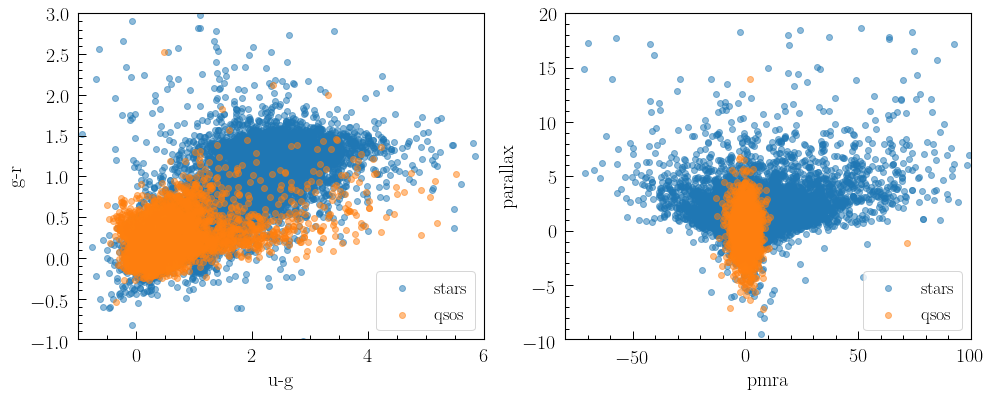

In [31]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].scatter(train_df[starmask]['stdColor[0]'],train_df[starmask]['stdColor[1]'],label='stars',alpha=0.5)
ax[0].scatter(train_df[qsomask]['stdColor[0]'],train_df[qsomask]['stdColor[1]'],label='qsos',alpha=0.5)
ax[0].legend(loc='lower right')
ax[0].set_xlim(-1,6)
ax[0].set_ylim(-1,3)
ax[0].set_xlabel('u-g')
ax[0].set_ylabel('g-r')

ax[1].scatter(train_df[starmask]['pmra'],train_df[starmask]['parallax'],label='stars',alpha=0.5)
ax[1].scatter(train_df[qsomask]['pmra'],train_df[qsomask]['parallax'],label='qsos',alpha=0.5)
ax[1].legend(loc='lower right')
ax[1].set_xlim(-80,100)
ax[1].set_ylim(-10,20)
ax[1].set_xlabel('pmra')
ax[1].set_ylabel('parallax')